# Finding Donors for Charity Organization

<a  align=center><img src = "https://miro.medium.com/max/963/0*181Nbv4t1bPcXXXe.jpg" width = 1400> </a>

<h1 align=center><font size = 5>Supervised Learning - Ensemble Techniques</font></h1>

----
## Introduction

In this project, you will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data.

Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

----
## Exploring the Data

In [1]:
pip install shap

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
#from scikitplot.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.base import clone

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
data = pd.read_csv("/content/census.csv")
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [5]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data["income"]==">50K"])

# Number of records where individual's income is at most $50,000
n_less_50k = len(data[data["income"]=="<=50K"])

# Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k/n_records)*100)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_less_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 25%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized.

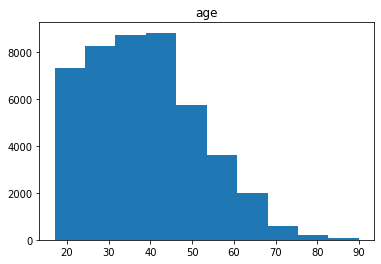

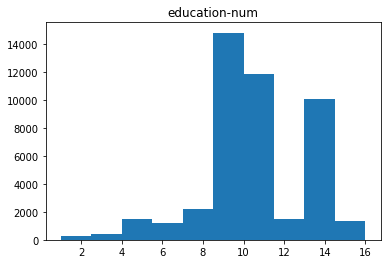

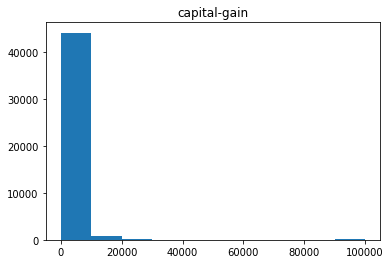

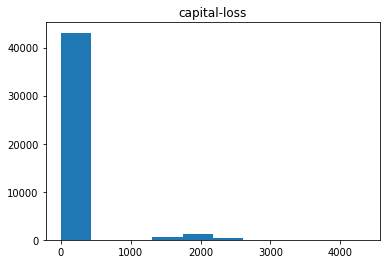

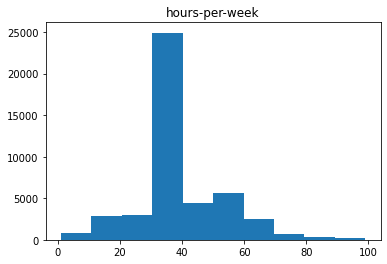

In [6]:
num_feature = data.columns[data.dtypes!='object']

def my_plot(feature):
    plt.hist(data[feature])
    plt.title(feature)
    plt.show()
        
for i in num_feature:
    my_plot(i)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

In [7]:
data['capital-gain_log'] = np.log((data['capital-gain'])+1)
data['capital-loss_log'] = np.log((data['capital-loss'])+1)

In [8]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,capital-gain_log,capital-loss_log
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,7.684784,0.0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,0.000000,0.0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,0.000000,0.0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,0.000000,0.0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,0.000000,0.0


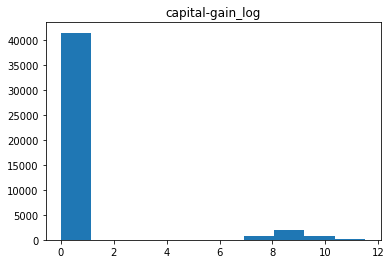

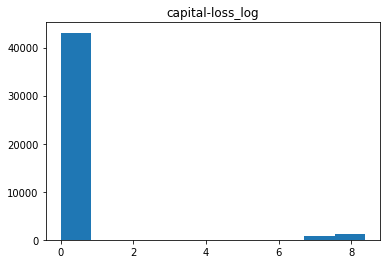

In [9]:
for i in ['capital-gain_log', 'capital-loss_log']:
    my_plot(i)

In [10]:
data_log_transformed = data.drop(['capital-gain', 'capital-loss'], axis=1)
data_log_transformed.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-gain_log,capital-loss_log
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,40.0,United-States,<=50K,7.684784,0.0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,13.0,United-States,<=50K,0.000000,0.0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,<=50K,0.000000,0.0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,<=50K,0.000000,0.0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,<=50K,0.000000,0.0


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [11]:
# Encode the 'income_label' data to numerical values
data_log_transformed['income'].replace({"<=50K":0, ">50K":1}, inplace=True)
data_log_transformed.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income,capital-gain_log,capital-loss_log
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,40.0,United-States,0,7.684784,0.0
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,13.0,United-States,0,0.000000,0.0
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,40.0,United-States,0,0.000000,0.0
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40.0,United-States,0,0.000000,0.0
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40.0,Cuba,0,0.000000,0.0


In [12]:
# One-hot encode the categorical features data
data_cat_transformed = pd.get_dummies(data_log_transformed, drop_first=True)

# Print the number of features after one-hot encoding
print("{} total features after one-hot encoding.".format(len(data_cat_transformed.columns)))
print(data_cat_transformed.columns)

96 total features after one-hot encoding.
Index(['age', 'education-num', 'hours-per-week', 'income', 'capital-gain_log',
       'capital-loss_log', 'workclass_ Local-gov', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay',
       'education_level_ 11th', 'education_level_ 12th',
       'education_level_ 1st-4th', 'education_level_ 5th-6th',
       'education_level_ 7th-8th', 'education_level_ 9th',
       'education_level_ Assoc-acdm', 'education_level_ Assoc-voc',
       'education_level_ Bachelors', 'education_level_ Doctorate',
       'education_level_ HS-grad', 'education_level_ Masters',
       'education_level_ Preschool', 'education_level_ Prof-school',
       'education_level_ Some-college', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [13]:
# Split the data into features and target label
X = data_cat_transformed.drop('income', axis=1)
y = data_cat_transformed['income']

In [14]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [15]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Show an example with scaling applied
X_train_scaled

array([[0.4109589 , 0.6       , 0.5       , ..., 1.        , 0.        ,
        0.        ],
       [0.43835616, 0.53333333, 0.39795918, ..., 1.        , 0.        ,
        0.        ],
       [0.05479452, 0.66666667, 0.35714286, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.56164384, 0.8       , 0.55102041, ..., 1.        , 0.        ,
        0.        ],
       [0.53424658, 0.53333333, 0.39795918, ..., 1.        , 0.        ,
        0.        ],
       [0.23287671, 0.53333333, 0.34693878, ..., 1.        , 0.        ,
        0.        ]])

In [17]:
y_train

13181    0
10342    0
20881    0
24972    1
43867    0
        ..
30403    0
21243    1
42613    1
43567    0
2732     0
Name: income, Length: 36177, dtype: int64

In [18]:
y_train_scaled = y_train.reset_index(drop=True)
y_train_scaled

0        0
1        0
2        0
3        1
4        0
        ..
36172    0
36173    1
36174    1
36175    0
36176    0
Name: income, Length: 36177, dtype: int64

In [19]:
y_test_scaled = y_test.reset_index(drop=True)
y_test_scaled

0       0
1       0
2       0
3       0
4       0
       ..
9040    0
9041    0
9042    0
9043    0
9044    1
Name: income, Length: 9045, dtype: int64

Observation of X_train dataframe before and after Scaling

In [20]:
X_train.head()

,age,education-num,hours-per-week,capital-gain_log,capital-loss_log,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_level_ 11th,education_level_ 12th,education_level_ 1st-4th,education_level_ 5th-6th,education_level_ 7th-8th,education_level_ 9th,education_level_ Assoc-acdm,education_level_ Assoc-voc,education_level_ Bachelors,education_level_ Doctorate,education_level_ HS-grad,education_level_ Masters,education_level_ Preschool,education_level_ Prof-school,education_level_ Some-college,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
13181,47,10.0,50.0,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10342,49,9.0,40.0,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
20881,21,11.0,36.0,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
24972,39,14.0,45.0,0.0,7.589842,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43867,35,10.0,50.0,0.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [21]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94
0,0.410959,0.600000,0.500000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.438356,0.533333,0.397959,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.054795,0.666667,0.357143,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.301370,0.866667,0.448980,0.0,0.905759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.246575,0.600000,0.500000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


----
## Evaluating Model Performance
In this section, we will investigate 3 different algorithms, and determine which is best at modeling the data.

### Metrics and the Naive Predictor
*Charity Organization*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *Charity Organization* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-1 score** as a metric that considers both precision and recall:


#### Note: Recap of Accuracy, Precision, Recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

`[(True Positives + True Negatives)/(True Positives + False Positives)]`

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity) ** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using the training data and perform predictions on the testing data.

In [22]:
def train_predict(classifier): 
    '''
    inputs:
       - classifier: the learning algorithm to be trained and predicted on
    '''
    
    results = {}
    
    # Fit the classifier to the training data and Calculate the time
    start_train = time()
    classifier = classifier.fit(X_train_scaled, y_train_scaled)
    end_train = time()
    results['train_time'] = round((end_train-start_train), 2)

    # Predict the training/testing labels and Calculate the time
    start_test = time()
    y_pred_train = classifier.predict(X_train_scaled)
    y_pred_test = classifier.predict(X_test_scaled)
    end_test = time()   
    results['pred_time'] = round((end_test-start_test), 2)
            
    # Model evaluation (training/testing data) using accuracy
    results['acc_train'] = round(accuracy_score(y_train_scaled, y_pred_train), 2)
    results['acc_test'] = round(accuracy_score(y_test_scaled, y_pred_test), 2)
    
    # Model evaluation (training/testing data) using f1-score
    results['f1_train'] = round(f1_score(y_train_scaled, y_pred_train), 2)
    results['f1_test'] = round(f1_score(y_test_scaled, y_pred_test), 2)
    
    # Display classification_report
    report = classification_report(y_test_scaled, y_pred_test)
       
    
    # Return the results
    return results, report

### Implementation: Initial Model Evaluation

In [23]:
# Initialize the classifiers
clf_DT = DecisionTreeClassifier(random_state=0)
clf_LR = LogisticRegression(random_state=0)
clf_SVM = SVC(random_state=0)
# KNN model requires you to specify n_neighbors,
# the number of points the classifier will look at to determine what class a new point belongs to
clf_KNN  = KNeighborsClassifier(n_neighbors=5)
clf_Gaussian = GaussianNB()
clf_Linear = LinearDiscriminantAnalysis()
clf_Multi = MultinomialNB()

clf_list = [clf_DT, clf_LR, clf_SVM, clf_KNN, clf_Gaussian, clf_Linear,clf_Multi]

# Compare evaluation of the different classifiers
clf_evaluation = {}
clf_report = {}

for clf in clf_list:
    clf_evaluation[clf.__class__.__name__], clf_report[clf.__class__.__name__] = train_predict(clf)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [24]:
clf_evaluation

{'DecisionTreeClassifier': {'acc_test': 0.82,
  'acc_train': 0.97,
  'f1_test': 0.62,
  'f1_train': 0.94,
  'pred_time': 0.02,
  'train_time': 0.35},
 'GaussianNB': {'acc_test': 0.58,
  'acc_train': 0.58,
  'f1_test': 0.52,
  'f1_train': 0.52,
  'pred_time': 0.05,
  'train_time': 0.06},
 'KNeighborsClassifier': {'acc_test': 0.82,
  'acc_train': 0.87,
  'f1_test': 0.62,
  'f1_train': 0.73,
  'pred_time': 35.1,
  'train_time': 0.01},
 'LinearDiscriminantAnalysis': {'acc_test': 0.84,
  'acc_train': 0.84,
  'f1_test': 0.65,
  'f1_train': 0.65,
  'pred_time': 0.02,
  'train_time': 0.73},
 'LogisticRegression': {'acc_test': 0.84,
  'acc_train': 0.84,
  'f1_test': 0.65,
  'f1_train': 0.65,
  'pred_time': 0.01,
  'train_time': 1.29},
 'MultinomialNB': {'acc_test': 0.82,
  'acc_train': 0.82,
  'f1_test': 0.64,
  'f1_train': 0.65,
  'pred_time': 0.03,
  'train_time': 0.02},
 'SVC': {'acc_test': 0.84,
  'acc_train': 0.85,
  'f1_test': 0.64,
  'f1_train': 0.66,
  'pred_time': 90.93,
  'train_time'

In [25]:
print(clf_report['DecisionTreeClassifier'])

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6840
           1       0.63      0.61      0.62      2205

    accuracy                           0.82      9045
   macro avg       0.75      0.75      0.75      9045
weighted avg       0.82      0.82      0.82      9045



In [26]:
print(clf_report['LogisticRegression'])

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6840
           1       0.71      0.60      0.65      2205

    accuracy                           0.84      9045
   macro avg       0.79      0.76      0.77      9045
weighted avg       0.84      0.84      0.84      9045



In [27]:
print(clf_report['SVC'])

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6840
           1       0.71      0.58      0.64      2205

    accuracy                           0.84      9045
   macro avg       0.79      0.75      0.77      9045
weighted avg       0.83      0.84      0.83      9045



In [28]:
print(clf_report['KNeighborsClassifier'])

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6840
           1       0.65      0.59      0.62      2205

    accuracy                           0.82      9045
   macro avg       0.76      0.74      0.75      9045
weighted avg       0.82      0.82      0.82      9045



In [29]:
print(clf_report['GaussianNB'])

              precision    recall  f1-score   support

           0       0.96      0.47      0.63      6840
           1       0.36      0.93      0.52      2205

    accuracy                           0.58      9045
   macro avg       0.66      0.70      0.57      9045
weighted avg       0.81      0.58      0.60      9045



In [30]:
print(clf_report['LinearDiscriminantAnalysis'])

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6840
           1       0.71      0.59      0.65      2205

    accuracy                           0.84      9045
   macro avg       0.79      0.76      0.77      9045
weighted avg       0.84      0.84      0.84      9045



In [31]:
print(clf_report['MultinomialNB'])

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6840
           1       0.63      0.65      0.64      2205

    accuracy                           0.82      9045
   macro avg       0.76      0.76      0.76      9045
weighted avg       0.82      0.82      0.82      9045



In [32]:
legend = []
for i in range(len(clf_list)):
    legend.append(clf_list[i].__class__.__name__)

In [33]:
def eval_plot(labels, y_label, title):

    clf1 = [clf_evaluation[legend[0]][labels[0]], clf_evaluation[legend[0]][labels[1]]]
    clf2 = [clf_evaluation[legend[1]][labels[0]], clf_evaluation[legend[1]][labels[1]]]
    clf3 = [clf_evaluation[legend[2]][labels[0]], clf_evaluation[legend[2]][labels[1]]]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - width/2, clf1, width, label=legend[0])
    ax.bar(x + width/2, clf2, width, label=legend[1])
    ax.bar(x + width*3/2, clf3, width, label=legend[2])

    # Add labels, title, and legend
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add bars annotation
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+(width/2), i.get_height()+0.01,
                str(i.get_height()), fontsize=11,
                color='black', ha='center')

    plt.show()

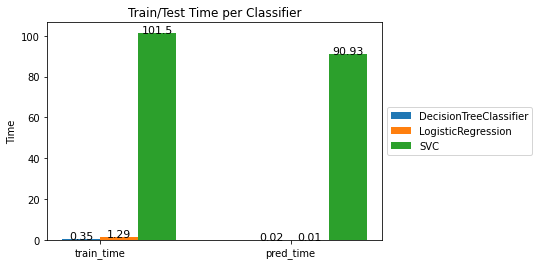

In [34]:
labels = ['train_time', 'pred_time']
y_label = 'Time'
title = 'Train/Test Time per Classifier'
eval_plot(labels, y_label, title)

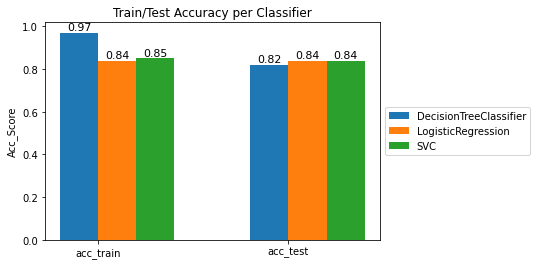

In [35]:
labels = ['acc_train', 'acc_test']
y_label = 'Acc_Score'
title = 'Train/Test Accuracy per Classifier'
eval_plot(labels, y_label, title)

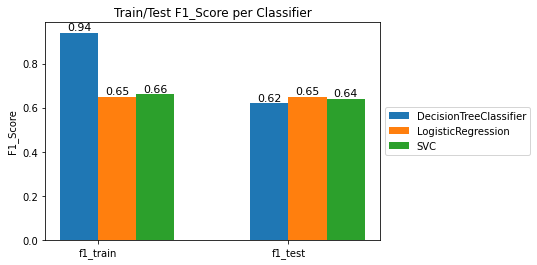

In [36]:
labels = ['f1_train', 'f1_test']
y_label = 'F1_Score'
title = 'Train/Test F1_Score per Classifier'
eval_plot(labels, y_label, title)

In [37]:
def eval_plot(labels, y_label, title):

    clf4 = [clf_evaluation[legend[3]][labels[0]], clf_evaluation[legend[3]][labels[1]]]
    clf5 = [clf_evaluation[legend[4]][labels[0]], clf_evaluation[legend[4]][labels[1]]]
    clf6 = [clf_evaluation[legend[5]][labels[0]], clf_evaluation[legend[5]][labels[1]]]
    clf7 = [clf_evaluation[legend[6]][labels[0]], clf_evaluation[legend[6]][labels[1]]]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
   
    ax.bar(x + width*3/2, clf4, width, label=legend[3])
    ax.bar(x + width*3/2, clf5, width, label=legend[4])
    ax.bar(x + width*3/2, clf6, width, label=legend[5])
    ax.bar(x + width*3/2, clf7, width, label=legend[6])

    # Add labels, title, and legend
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add bars annotation
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+(width/2), i.get_height()+0.01,
                str(i.get_height()), fontsize=11,
                color='black', ha='center')

    plt.show()

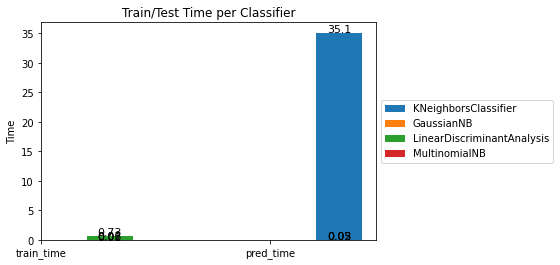

In [38]:
labels = ['train_time', 'pred_time']
y_label = 'Time'
title = 'Train/Test Time per Classifier'
eval_plot(labels, y_label, title)

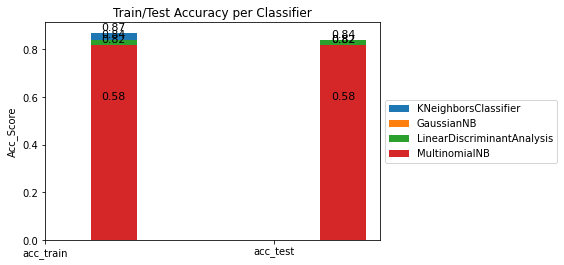

In [39]:
labels = ['acc_train', 'acc_test']
y_label = 'Acc_Score'
title = 'Train/Test Accuracy per Classifier'
eval_plot(labels, y_label, title)

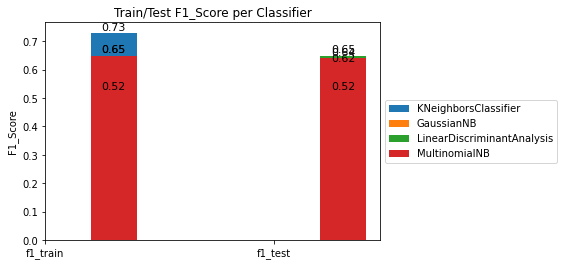

In [40]:
labels = ['f1_train', 'f1_test']
y_label = 'F1_Score'
title = 'Train/Test F1_Score per Classifier'
eval_plot(labels, y_label, title)

In [41]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor(n_estimators=1000).fit(X_train, y_train)

preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)

rmse

[16:34:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.30001124120989403

In [42]:
# Create a tree explainer
import shap
xgb_explainer = shap.TreeExplainer(
    model, X_train, feature_names=X_train.columns.tolist()
)

xgb_explainer


In [43]:
%%time
# Shap values with tree explainer
shap_values = xgb_explainer.shap_values(X_train, y_train)

shap_values.shape

100%|===================| 36067/36177 [04:19<00:00]       

CPU times: user 4min 19s, sys: 1.12 s, total: 4min 20s
Wall time: 4min 19s


In [44]:
%%time

# Shap values with XGBoost core moedl
booster_xgb = model.get_booster()

shap_values_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train), 
                                      pred_contribs=True)


CPU times: user 29.9 s, sys: 32.8 ms, total: 30 s
Wall time: 29.9 s


In [45]:
shap_values_xgb.shape

(36177, 96)

In [46]:
shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

,age,education-num,hours-per-week,capital-gain_log,capital-loss_log,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_level_ 11th,education_level_ 12th,education_level_ 1st-4th,education_level_ 5th-6th,education_level_ 7th-8th,education_level_ 9th,education_level_ Assoc-acdm,education_level_ Assoc-voc,education_level_ Bachelors,education_level_ Doctorate,education_level_ HS-grad,education_level_ Masters,education_level_ Preschool,education_level_ Prof-school,education_level_ Some-college,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.089917,-0.010070,0.054689,-0.022918,-0.007934,0.004291,-0.007161,-0.000011,0.009757,0.001585,0.000081,0.000629,-0.000003,-0.000003,-0.000009,0.000017,2.155268e-06,0.000121,-0.000260,0.001247,0.0,-0.000425,0.000154,0.0,-0.000648,0.000093,-0.000226,0.145939,0.000007,0.000182,-0.000271,-0.000500,0.0,0.000647,-0.016847,0.004490,0.003249,0.003093,0.006625,0.000326,...,-0.000256,0.000058,0.000176,-0.000080,0.000115,-0.000002,-0.000010,-0.000149,-0.000072,-0.000039,0.000020,-4.510524e-07,-0.000004,0.0,-9.648938e-07,0.000026,-0.000013,0.000120,8.304522e-07,-0.000187,-0.000034,-0.000001,0.000040,0.000025,0.000647,0.000038,0.000031,0.000077,-0.000075,-0.000002,-0.000115,0.000125,0.000022,0.000195,-0.000002,0.000036,0.000107,0.001699,0.000137,-0.000014
1,0.067247,-0.082122,-0.001000,-0.023990,-0.009197,0.002372,-0.013739,-0.000109,0.009237,0.001006,0.000081,0.000034,-0.000003,-0.000003,-0.000072,0.000125,2.155268e-06,0.000011,-0.001347,0.001034,0.0,0.001181,0.000167,0.0,-0.000250,-0.000061,-0.000185,0.122592,-0.000047,-0.000901,0.000031,-0.000291,0.0,0.000640,-0.014123,0.004345,0.002203,-0.033374,0.007721,0.000291,...,-0.000460,-0.000010,0.000176,-0.000102,0.000072,0.000008,-0.000010,-0.000201,-0.000119,-0.000015,0.000038,-4.510524e-07,-0.000004,0.0,-8.942621e-07,0.000026,-0.000013,0.000120,8.514614e-07,-0.000020,-0.000137,0.000015,0.000038,0.000017,0.000682,-0.000023,0.000046,0.000083,-0.000070,-0.000009,0.000032,0.000132,0.000023,0.000364,-0.000002,0.000039,0.000066,0.001817,0.000073,-0.000019
2,-0.043907,-0.015489,-0.013581,-0.024937,-0.007839,0.002679,-0.005251,-0.000643,0.003977,0.001647,0.000096,0.000025,0.000004,-0.000003,-0.000062,-0.000023,6.574937e-07,-0.000003,0.005627,0.001008,0.0,-0.000060,0.000258,0.0,-0.000302,0.000002,-0.000195,-0.103894,-0.000178,-0.000618,0.000031,-0.000400,0.0,0.000521,-0.006777,0.001626,0.000891,0.001209,-0.018088,0.000026,...,-0.000265,-0.000049,0.000092,-0.000062,-0.000069,0.000004,-0.000010,-0.000137,-0.000038,0.000002,0.000038

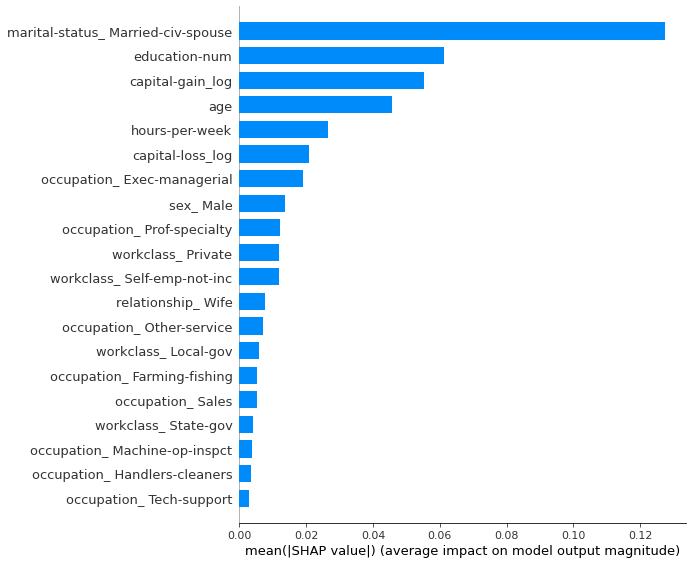

In [47]:
shap.summary_plot(
    shap_values_xgb, X_train, 
    feature_names=X_train.columns, plot_type="bar")

In [48]:
pd.DataFrame(shap_values_xgb, columns=X_train.columns)["marital-status_ Married-civ-spouse"].abs().mean()

0.12732446193695068

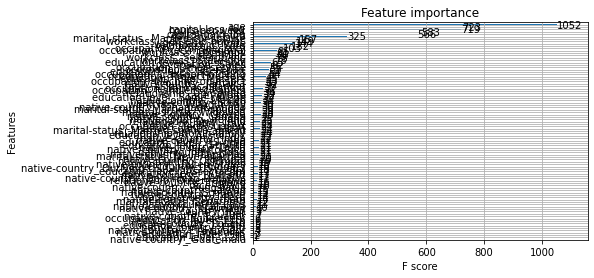

In [49]:
xgb.plot_importance(booster_xgb)

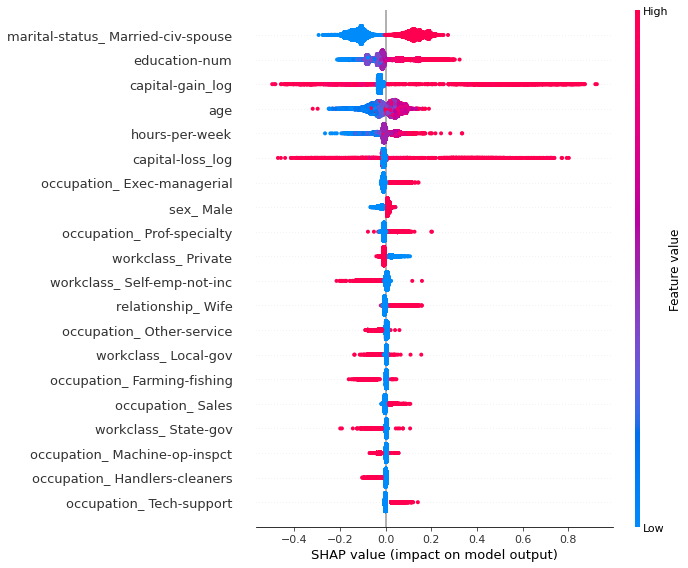

In [50]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns);

Exploring each feature with dependence plots

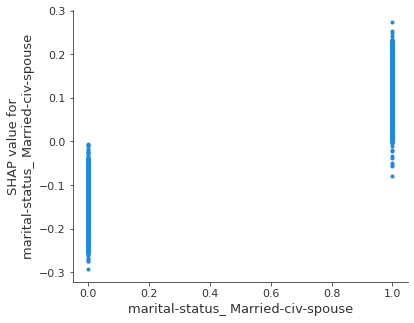

In [51]:
shap.dependence_plot("marital-status_ Married-civ-spouse", shap_values_xgb, X_train, interaction_index=None)

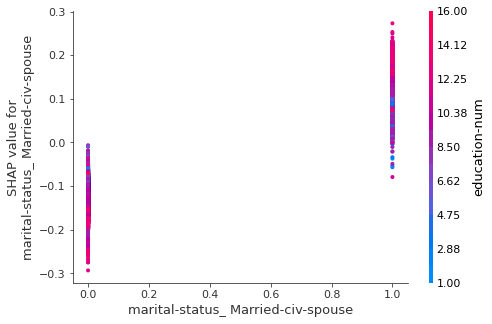

In [52]:
shap.dependence_plot("marital-status_ Married-civ-spouse", shap_values_xgb, 
                      X_train, interaction_index="auto");

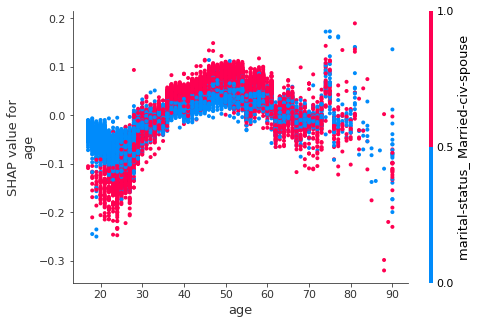

In [53]:

shap.dependence_plot("age", shap_values_xgb, X_train, 
                    feature_names=X_train.columns);

In [54]:
interactions = xgb_explainer.shap_interaction_values(X_train, y_train)

In [55]:
#%%time

# SHAP interactions with XGB
interactions_xgb = booster_xgb.predict(
    xgb.DMatrix(X_train, y_train), pred_interactions=True
)


In [56]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j] * 2,
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]


top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

In [57]:
top_10_inter_feats

('marital-status_ Married-civ-spouse-education-num',
 'marital-status_ Married-civ-spouse-age',
 'marital-status_ Married-civ-spouse-capital-gain_log',
 'capital-gain_log-education-num',
 'education-num-age',
 'hours-per-week-age',
 'sex_ Male-age',
 'marital-status_ Married-civ-spouse-hours-per-week',
 'hours-per-week-education-num',
 'occupation_ Exec-managerial-marital-status_ Married-civ-spouse')

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


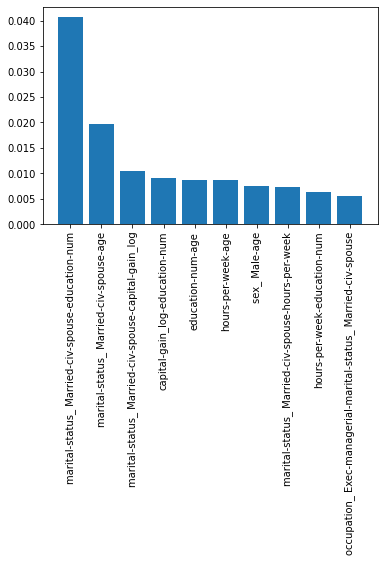

In [58]:
def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();
    

top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)